In [14]:

import torch
import torchvision
import torchvision.transforms as transforms
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import cv2
import sklearn
import torch.nn as nn
import torch.nn.functional as F

from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.utils.data import DataLoader, TensorDataset

from torch.autograd import Variable

In [15]:

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [16]:


num_epochs = 4
batch_size = 4
learning_rate = 0.001
class CNN(nn.Module):
  def __init__(self, inputs=2, outputs=1, hidden = 64):
    #call the super class
    super(CNN, self).__init__()
    #here we construct the functions used in the network

    #layer 1
    self.conv1 = Conv2d(in_channels=3, out_channels=20, kernel_size=(3, 3))
    
    #out image = (32-3) +1 after pooling -> 15
    #layer 2
    self.conv2 = Conv2d(in_channels=20, out_channels=16, kernel_size=(3, 3))

    #out image = 15-3 +1 
    #layer 3
    self.fc1 = Linear(in_features=16*13*13, out_features=256)

    #layer 4
    self.fc2 = Linear(in_features=256, out_features=10)

    #pooling functions
    self.pool = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

  def forward(self, x):
    #pass the input through the layers
    x = self.pool(F.relu(self.conv1(x))) #layer 1
    x =(F.relu(self.conv2(x))) #layer 2

    x = torch.flatten(x, 1)

    x = self.fc1(x)
    x = self.fc2(x)

    return x





In [23]:
import warnings
import torch.optim as optim

net = CNN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)


#declare loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


#loop over our data iterator and feed the inputs to the network and optimize.
loss_array = []

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        x_tensor, y_tensor = data

        # zero the parameter gradients since we are at new epoch
        optimizer.zero_grad()

        

        #forward step
        outputs = net(x_tensor)

        loss = loss_fn(outputs, y_tensor) #calculate loss


        
        #backward step
        loss.backward()
        
        #optimize
        optimizer.step()

        # print statistics
        running_loss += loss.item()


        
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            loss_array = np.append(loss_array, running_loss/2000)
            running_loss = 0.0





[1,  2000] loss: 1.818
[1,  4000] loss: 1.435
[2,  2000] loss: 1.269
[2,  4000] loss: 1.215
[3,  2000] loss: 1.119
[3,  4000] loss: 1.106
[4,  2000] loss: 1.021
[4,  4000] loss: 1.019
[5,  2000] loss: 0.975
[5,  4000] loss: 0.968


Text(0.5, 0, 'epoch')

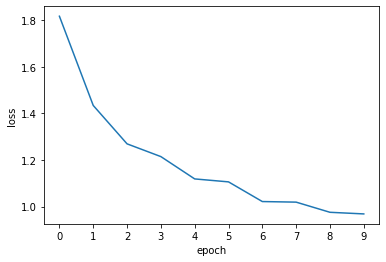

In [25]:


plt.plot(loss_array)
plt.xticks(np.arange(10))

plt.ylabel('loss')
plt.xlabel('epoch')

In [ ]:
total = 0;
correct = 0;
with torch.no_grad():
      for data in testloader:
          images, labels = data
          #print(labels)
          # calculate outputs by running images through the network
          outputs = net(images)
          #print(outputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100*correct/total} %')

total = 0;
correct = 0;
with torch.no_grad():
      for data in trainloader:
          images, labels = data
          #print(labels)
          # calculate outputs by running images through the network
          outputs = net(images)
          #print(outputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 50000 train images: {100*correct/total} %')

Accuracy of the network on the 10000 test images: 64.41 %
Accuracy of the network on the 50000 train images: 67.674 %


In [ ]:
%pip install patool
import patoolib
import pandas as pd
import numpy as np
import requests
import os
from keras.datasets import cifar10
import cv2

from keras.utils.np_utils import to_categorical   


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Transform label indices to one-hot encoded vectors

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3) (flatten the arrays)

X_train = np.reshape(X_train,(50000,3072))
X_test = np.reshape(X_test,(10000,3072))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# zero-centering of pixel values using mean FROM THE TRAINING SET (IMPORTANT)

X_train -= np.mean(X_train, axis = 0)
X_test -= np.mean(X_train, axis = 0)

#Unnormalized set
X_train_unnormalized = X_train

# Normalization of RGB pixel values (to [0-1] range)

X_train /= 255
X_test /= 255


#get the training data covariance matrix

cov = np.dot(X_train.T, X_train) / X_train.shape[0]

#compute the SVD factorization of the data covariance matrix

U,S,V = np.linalg.svd(cov)

#Decorrelate the data 

X_train_rot = np.dot(X_train, U) 
X_test_rot = np.dot(X_test, U) 

#Xrot_reduced becomes [N x 100] (PCA DIMENSION REDUCTION)

#X_train_rot_reduced = np.dot(X_train_rot, U[:,:100])
#X_test_rot_reduced = np.dot(X_test_rot, U[:,:100]) 

##Data Whitening (On the PCA filtered data)

epsilon = 1e-5

#Divide by the eigenvalues (which are square roots of the singular values) P.S smoothing data by choosing a larger epsilon
Xwhite_train = X_train_rot / np.sqrt(S + epsilon)
Xwhite_test = X_test_rot / np.sqrt(S + epsilon)

x_train=Xwhite_train.reshape(50000, 32, 32, 3)
x_test=Xwhite_test.reshape(10000, 32, 32, 3)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 6.0 MB/s eta 0:00:00
170498071/170498071 [==============================] - 6s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = 5, activation = 'relu', input_shape = (32, 32, 3)))

model.add(layers.MaxPooling2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 20, kernel_size = 3, activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(units = 256, activation = 'relu'))
model.add(layers.Dense(units = 10, activation = 'relu'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1563/1563 [==============================] - 88s 55ms/step - loss: 6.1979 - accuracy: 0.1391 - val_loss: 6.1604 - val_accuracy: 0.1581
Epoch 2/10
1563/1563 [==============================] - 70s 45ms/step - loss: 6.1589 - accuracy: 0.1522 - val_loss: 6.1431 - val_accuracy: 0.1747
Epoch 3/10
1563/1563 [==============================] - 77s 49ms/step - loss: 6.1452 - accuracy: 0.1645 - val_loss: 6.1302 - val_accuracy: 0.1774
Epoch 4/10
1563/1563 [==============================] - 70s 45ms/step - loss: 6.1396 - accuracy: 0.1655 - val_loss: 6.1392 - val_accuracy: 0.1803
Epoch 5/10
1563/1563 [==============================] - 71s 45ms/step - loss: 6.1150 - accuracy: 0.1864 - val_loss: 6.1109 - val_accuracy: 0.1917
Epoch 6/10
1563/1563 [==============================] - 69s 44ms/step - loss: 6.1351 - accuracy: 0.1671 - val_loss: 6.1094 - val_accuracy: 0.1839
Epoch 7/10
1563/1563 [==============================] - 70s 45ms/step - loss: 6.1445 - accuracy: 0.1548 - val_loss: 6.1540 -

Text(0.5, 0, 'epoch')

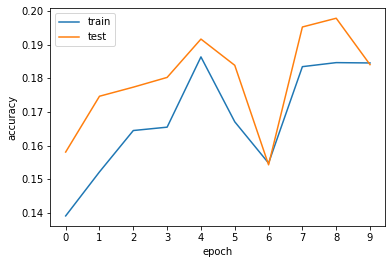

In [6]:
import numpy as np
import matplotlib.pyplot as plt

train_accuracy = [0.1391,0.1522,0.1645,0.1655,0.1864,0.1671,0.1548, 0.1835, 0.1847,0.1846]
test_accuracy = [0.1581,0.1747,0.1774,0.1803,0.1917,0.1839,0.1543,0.1953,0.1979,0.1841]

plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.xticks(np.arange(10))
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [17]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))



Epoch 1/10
1563/1563 [==============================] - 66s 42ms/step - loss: 2.1262 - accuracy: 0.1829 - val_loss: 2.0623 - val_accuracy: 0.2412
Epoch 2/10
1563/1563 [==============================] - 67s 43ms/step - loss: 2.0316 - accuracy: 0.2575 - val_loss: 1.9380 - val_accuracy: 0.2578
Epoch 3/10
1563/1563 [==============================] - 67s 43ms/step - loss: 2.0006 - accuracy: 0.2690 - val_loss: 2.1736 - val_accuracy: 0.2052
Epoch 4/10
1563/1563 [==============================] - 66s 42ms/step - loss: 2.0565 - accuracy: 0.2330 - val_loss: 1.9075 - val_accuracy: 0.2938
Epoch 5/10
1563/1563 [==============================] - 66s 42ms/step - loss: 1.9731 - accuracy: 0.3149 - val_loss: 1.9054 - val_accuracy: 0.3121
Epoch 6/10
1563/1563 [==============================] - 68s 43ms/step - loss: 1.9268 - accuracy: 0.3146 - val_loss: 1.9142 - val_accuracy: 0.3754
Epoch 7/10
1563/1563 [==============================] - 66s 42ms/step - loss: 1.9366 - accuracy: 0.3050 - val_loss: 2.1826 -

Text(0.5, 0, 'epoch')

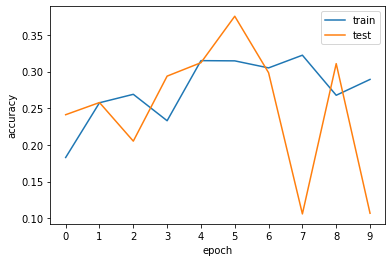

In [5]:
import matplotlib.pyplot as plt
import numpy as np
train_accuracy = [0.1829,0.2575,0.2690,0.2330,0.3149,0.3146,0.3050,0.3223,0.2677,0.2893]
test_accuracy = [0.2412,0.2578,0.2052,0.2938,0.3121,0.3754,0.2984,0.1060,0.3108,0.1069]

plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.xticks(np.arange(10))
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [4]:




import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

model = Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape = (32, 32, 3)))

model.add(layers.MaxPooling2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 16, kernel_size = 3, activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(units = 256, activation = 'relu'))
model.add(layers.Dense(units = 10, activation = 'relu'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))


Epoch 1/10
1563/1563 [==============================] - 55s 34ms/step - loss: 7.5231 - accuracy: 0.1901 - val_loss: 7.3725 - val_accuracy: 0.2725
Epoch 2/10
1563/1563 [==============================] - 56s 36ms/step - loss: 7.4297 - accuracy: 0.2024 - val_loss: 7.4792 - val_accuracy: 0.1331
Epoch 3/10
1563/1563 [==============================] - 58s 37ms/step - loss: 7.3737 - accuracy: 0.2470 - val_loss: 7.2961 - val_accuracy: 0.2869
Epoch 4/10
1563/1563 [==============================] - 52s 34ms/step - loss: 7.3514 - accuracy: 0.2524 - val_loss: 7.3660 - val_accuracy: 0.2307
Epoch 5/10
1563/1563 [==============================] - 53s 34ms/step - loss: 7.4069 - accuracy: 0.2139 - val_loss: 7.2851 - val_accuracy: 0.2822
Epoch 6/10
1563/1563 [==============================] - 52s 34ms/step - loss: 7.4095 - accuracy: 0.2124 - val_loss: 7.3473 - val_accuracy: 0.2628
Epoch 7/10
1563/1563 [==============================] - 56s 36ms/step - loss: 7.3241 - accuracy: 0.2698 - val_loss: 7.2242 -

Text(0.5, 0, 'epoch')

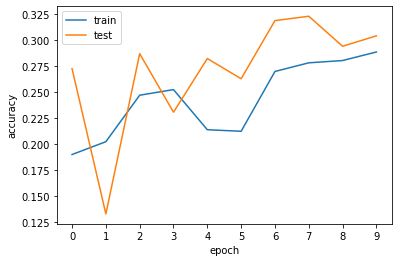

In [8]:
import numpy as np
test_accuracy = [0.2725,0.1331,0.2869,0.2307,0.2822,0.2628,0.3186,0.3228,0.2940, 0.3040]
train_accuracy = [0.1901,0.2024,0.2470,0.2524,0.2139,0.2124,0.2698,0.2781,0.2803,0.2885]

plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.xticks(np.arange(10))
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [7]:


import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

model = Sequential()
model.add(layers.Conv2D(filters = 32, kernel_size = 5, activation = 'relu', input_shape = (32, 32, 3)))

model.add(layers.MaxPooling2D(pool_size = (2, 2)))
model.add(layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(units = 256, activation = 'relu'))
model.add(layers.Dense(units = 10, activation = 'relu'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 68s 43ms/step - loss: 7.1977 - accuracy: 0.1351 - val_loss: 4.7781 - val_accuracy: 0.2008
Epoch 2/10
1563/1563 [==============================] - 69s 44ms/step - loss: 4.7916 - accuracy: 0.2067 - val_loss: 4.8426 - val_accuracy: 0.1265
Epoch 3/10
1563/1563 [==============================] - 80s 51ms/step - loss: 4.8275 - accuracy: 0.1771 - val_loss: 4.7719 - val_accuracy: 0.2117
Epoch 4/10
1563/1563 [==============================] - 81s 52ms/step - loss: 4.7855 - accuracy: 0.2105 - val_loss: 4.6701 - val_accuracy: 0.2973
Epoch 5/10
1563/1563 [==============================] - 68s 43ms/step - loss: 4.7442 - accuracy: 0.2411 - val_loss: 4.7178 - val_accuracy: 0.2170
Epoch 6/10
1563/1563 [==============================] - 64s 41ms/step - loss: 4.6449 - accuracy: 0.3067 - val_loss: 4.6437 - val_accuracy: 0.3295
Epoch 7/10
1563/1563 [==============================] - 64s 41ms/step - loss: 4.5877 - accuracy: 0.3162 - val_loss: 4.5985 -

In [ ]:
import numpy as np
test_accuracy = [0.2008, 01265,0.2117,0.2973,0.2170,0.3295,0.2772,0.1399,0.2329,0.1519]
train_accuracy = [0.1351,0.2067,0.1771,0.2105,02411,0.3067,0.3162,0.3115,0.2851,0.3502]

plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.xticks(np.arange(10))
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [10]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))

model.add(layers.MaxPooling2D(pool_size = (2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(units = 256, activation = 'relu'))
model.add(layers.Dense(units = 10, activation = 'relu'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 95s 60ms/step - loss: 7.4447 - accuracy: 0.1474 - val_loss: 6.1704 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 98s 63ms/step - loss: 3.6408 - accuracy: 0.1833 - val_loss: 3.3729 - val_accuracy: 0.2673
Epoch 3/10
1563/1563 [==============================] - 86s 55ms/step - loss: 3.4673 - accuracy: 0.1898 - val_loss: 3.5191 - val_accuracy: 0.2604
Epoch 4/10
1563/1563 [==============================] - 85s 54ms/step - loss: 3.4875 - accuracy: 0.2031 - val_loss: 3.3985 - val_accuracy: 0.2384
Epoch 5/10
1563/1563 [==============================] - 81s 52ms/step - loss: 3.4400 - accuracy: 0.2306 - val_loss: 3.3265 - val_accuracy: 0.2553
Epoch 6/10
1563/1563 [==============================] - 84s 54ms/step - loss: 3.3959 - accuracy: 0.2152 - val_loss: 3.3316 - val_accuracy: 0.2351
Epoch 7/10
1563/1563 [==============================] - 97s 62ms/step - loss: 3.3730 - accuracy: 0.2515 - val_loss: 3.2361 -

Text(0.5, 0, 'epoch')

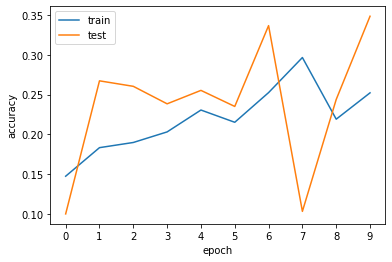

In [12]:
import numpy as np
test_accuracy = [0.1, 0.2673,0.2604,0.2384,0.2553,0.2351,0.3367,0.1032,0.2439,0.3485]
train_accuracy = [0.1474,0.1833,0.1898,0.2031,0.2306,0.2152,0.2525,0.2966,0.2191,0.2522]

plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.xticks(np.arange(10))
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('epoch')

In [11]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))

model.add(layers.MaxPooling2D(pool_size = (2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size = (2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(units = 256, activation = 'relu'))
model.add(layers.Dense(units = 10, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 111s 70ms/step - loss: 2.3112 - accuracy: 0.3068 - val_loss: 1.5053 - val_accuracy: 0.4529
Epoch 2/10
1563/1563 [==============================] - 82s 53ms/step - loss: 1.3511 - accuracy: 0.5201 - val_loss: 1.2637 - val_accuracy: 0.5548
Epoch 3/10
1563/1563 [==============================] - 81s 52ms/step - loss: 1.1369 - accuracy: 0.6026 - val_loss: 1.1819 - val_accuracy: 0.5905
Epoch 4/10
1563/1563 [==============================] - 79s 50ms/step - loss: 0.9956 - accuracy: 0.6540 - val_loss: 1.1529 - val_accuracy: 0.6107
Epoch 5/10
1563/1563 [==============================] - 80s 51ms/step - loss: 0.8776 - accuracy: 0.6953 - val_loss: 1.1883 - val_accuracy: 0.6135
Epoch 6/10
1563/1563 [==============================] - 79s 51ms/step - loss: 0.7706 - accuracy: 0.7338 - val_loss: 1.2197 - val_accuracy: 0.6238
Epoch 7/10
1563/1563 [==============================] - 80s 51ms/step - loss: 0.6744 - accuracy: 0.7681 - val_loss: 1.2687 

Text(0.5, 0, 'epoch')

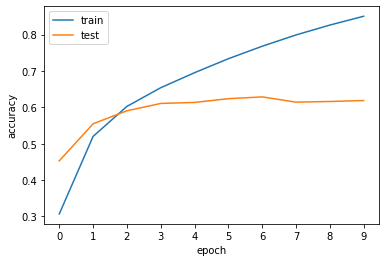

In [13]:
import numpy as np
test_accuracy = [0.4529,0.5548,0.5905,0.6107,0.6135,0.6238,0.6287, 0.6143,0.6161,0.6187]
train_accuracy = [0.3068,0.5201,0.6026,0.6540,0.6953,0.7338,0.7681,0.7992,0.8263,0.8506]

plt.plot(train_accuracy)
plt.plot(test_accuracy)
plt.xticks(np.arange(10))
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('epoch')